In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize

Text(0.5,1,'Possible beta distributions')

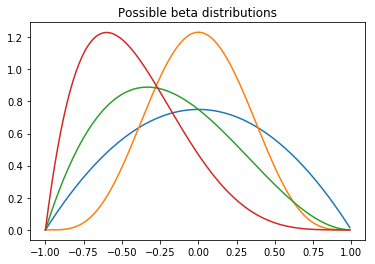

In [2]:
# plot the pdf within the range
x = np.arange (-1, 1, 0.01)

Y1 = st.beta(a = 2,b=2,loc=-1,scale=2)
z = Y1.pdf(x)
plt.plot(x,z)

Y2 = st.beta(a = 5,b=5,loc=-1,scale=2)
z = Y2.pdf(x)
plt.plot(x,z)

Y3 = st.beta(a = 2,b=3,loc=-1,scale=2)
z = Y3.pdf(x)
plt.plot(x,z)

Y4 = st.beta(a = 2,b=5,loc=-1,scale=2)
z = Y4.pdf(x)
plt.plot(x,z)
plt.title("Possible beta distributions")

In [4]:
def fit_beta(Y,n_samples,x_values,fit_type,plot_observed=False,**kwargs):
    #fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    fig, axs = plt.subplots(2,5, figsize=(12, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(10):
        S = Y.rvs(n_samples)
        
        if fit_type.lower() == 'mle':
            # fit a beta distribution using MLE
            a1, b1, loc1, scale1 = st.beta.fit(S,**kwargs)

            fitted_beta = st.beta(a = a1,b=b1,loc=loc1,scale=scale1)

            #plt.hist(S,normed=True)

            y_values = fitted_beta.pdf(x_values)
        elif fit_type.lower() == 'kde':
            # fit a kde, optimising bandwidth
            fitted = st.gaussian_kde(S,bw_method='scott')
            y_values = fitted.pdf(x_values)
        else:
            raise ValueError("Not a valid estimation method")
        
        if plot_observed:
            axs[i].hist(S,normed=True,label='Observed samples')
        axs[i].plot(x_values, y_values,label="Fitted pdf")
        axs[i].plot(x_values, Y.pdf(x_values),label='True pdf')
        axs[i].yaxis.set_visible(False)
    axs[i].legend()

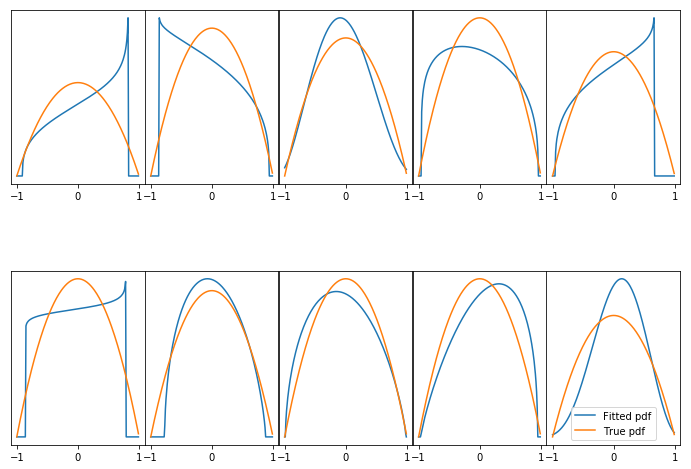

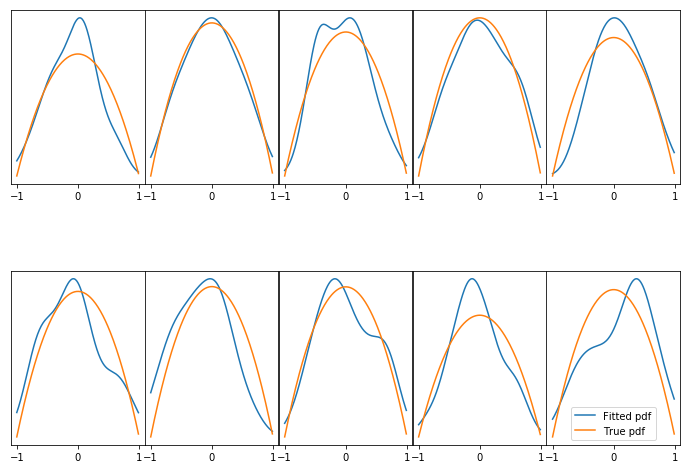

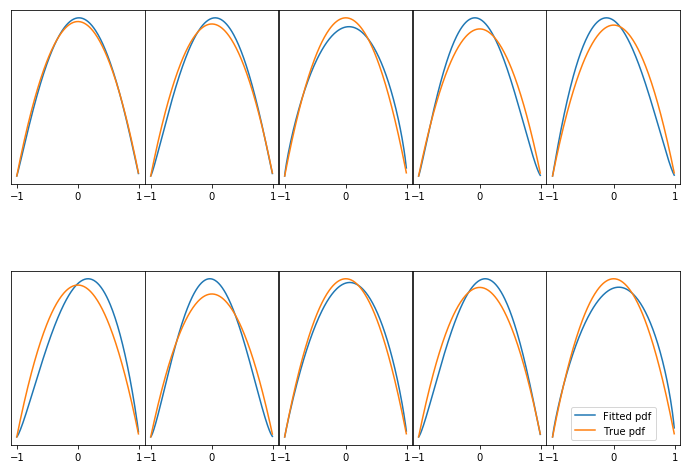

In [4]:
fit_beta(Y1,50,x,'mle')
fit_beta(Y1,50,x,'kde')
fit_beta(Y1,50,x,'mle',floc=-1,fscale=2)

/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


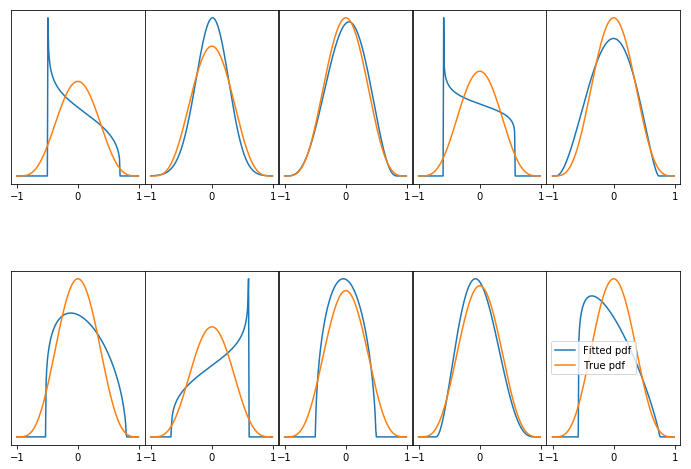

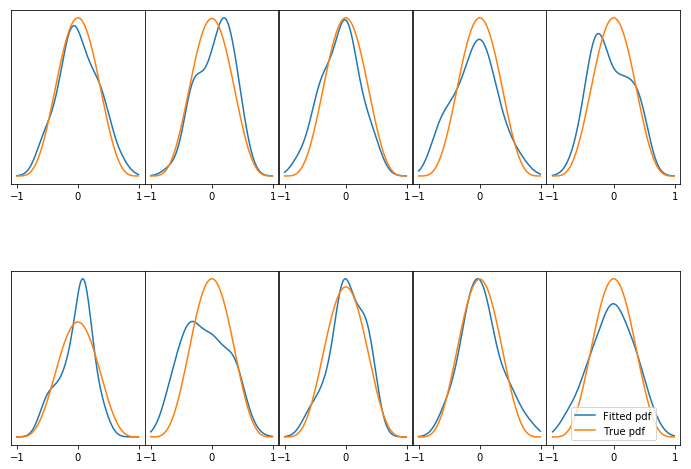

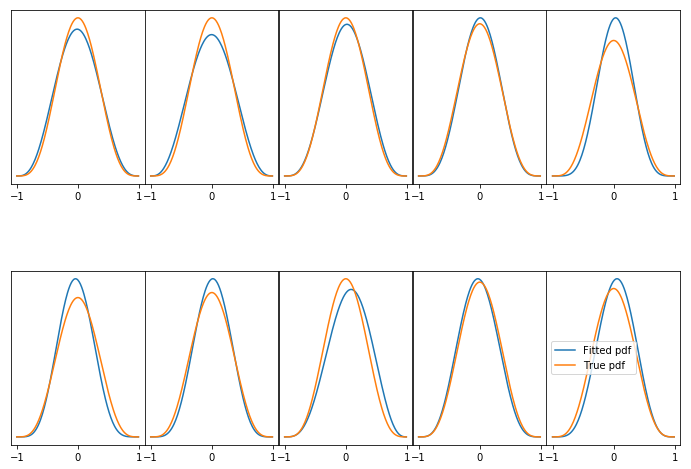

In [5]:
fit_beta(Y2,50,x,'mle')
fit_beta(Y2,50,x,'kde')
fit_beta(Y2,50,x,'mle',floc=-1,fscale=2)

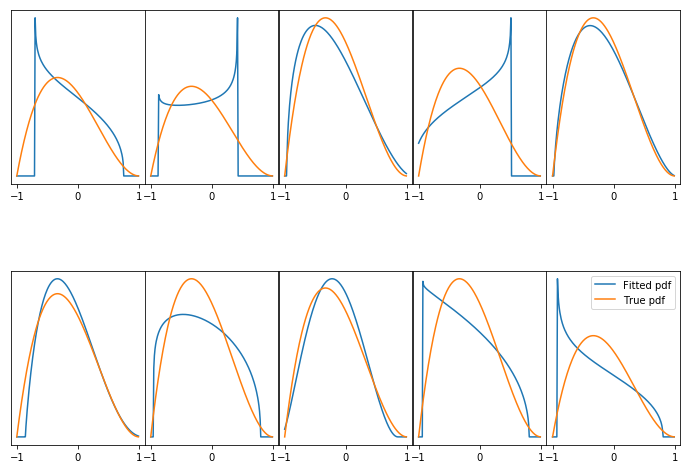

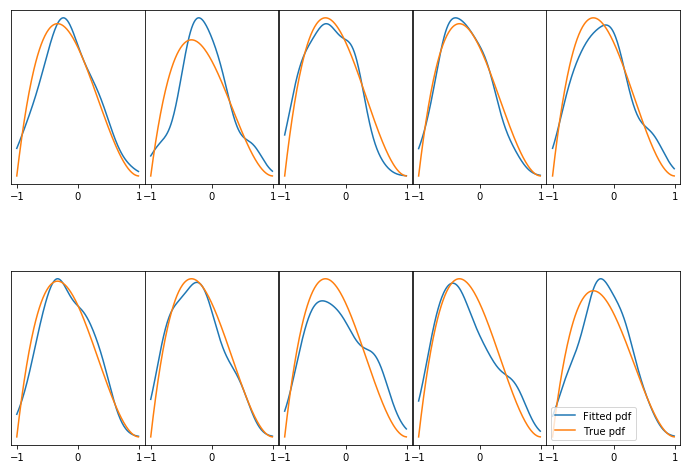

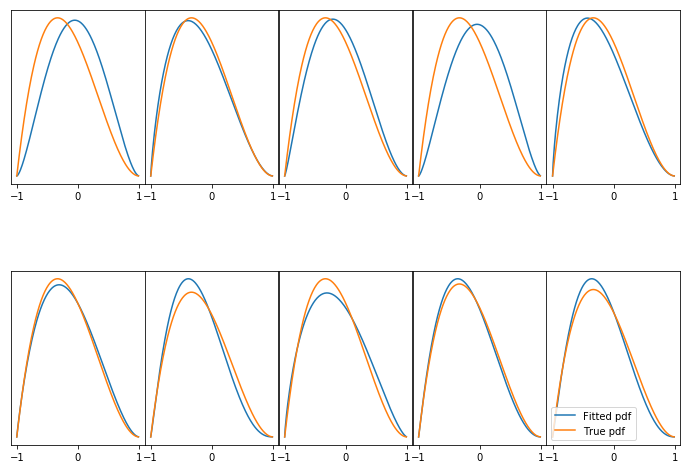

In [6]:
fit_beta(Y3,50,x,'mle')
fit_beta(Y3,50,x,'kde')
fit_beta(Y3,50,x,'mle',floc=-1,fscale=2)

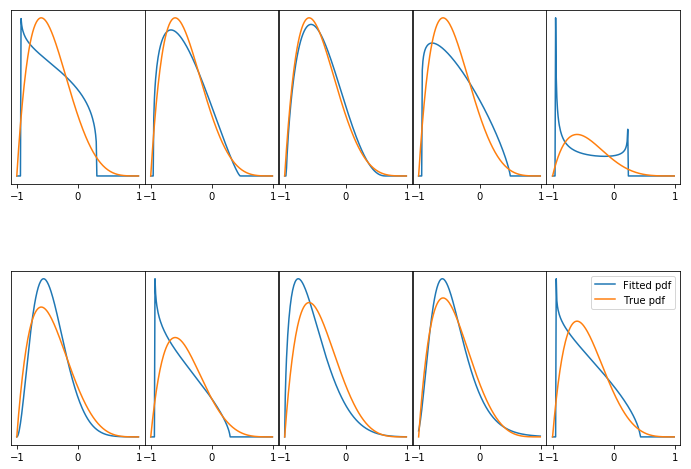

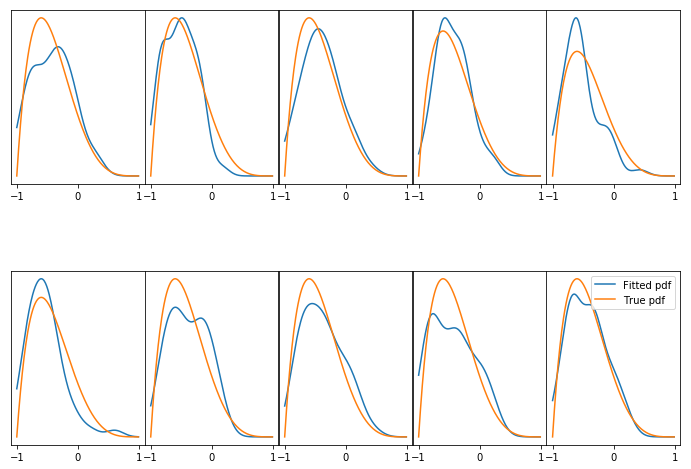

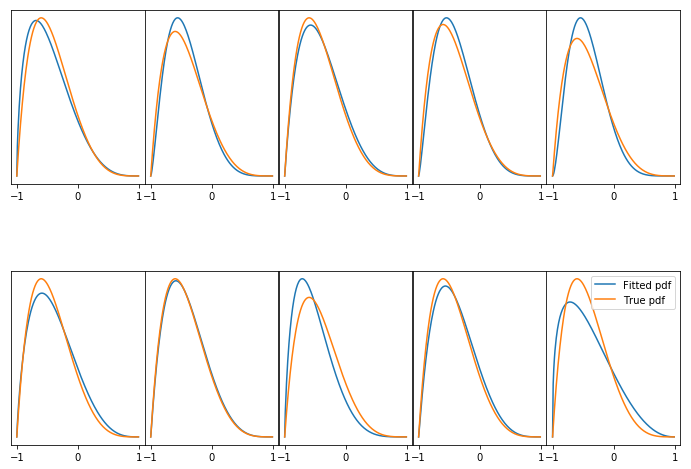

In [7]:
fit_beta(Y4,50,x,'mle')
fit_beta(Y4,50,x,'kde')
fit_beta(Y4,50,x,'mle',floc=-1,fscale=2)

In [102]:
N = [25,50,100,200]
n_iter = 500
n_samples = 1000

In [95]:
# simple quadratic cost function
# f1 = lambda x,y: -x*y + 0.2*x**2 
f1 = lambda x,y: -x*y + 5*x**2 + 2*x 

f3 = lambda x,y: 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y

f2 = lambda x,y: -x*y + 0.2*x**2

In [93]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [68]:
def minimise_dist(distribution,function,n_samples=1000):
    # minimises a cost function according to a given distribution
    samples = distribution.rvs(size=n_samples)
    
    # minimise the cost function
    res = minimize(function,0.0,args=(samples))
    return res.x

In [101]:
# concave function in x
f1_mean = lambda x,y: np.mean(f1(x,y),axis=0)
f2_mean = lambda x,y: np.mean(f2(x,y),axis=0)
f3_mean = lambda x,y: np.mean(f3(x,y),axis=0)

In [70]:
def minimise_methods(distribution,function,N,n_iter=500):
    results = np.zeros((3,n_iter,len(N)))
    for k in range(n_iter):
        for j in range(len(N)):
            # obtain the samples
            S = distribution.rvs(N[j])

            # maximise using SAA
            results[0,k,j]= minimize(function,0.0,args=(np.reshape(S,(-1)))).x


            # fit a beta distribution using MLE
            a1, b1, loc1, scale1 = st.beta.fit(S)

            fitted = st.beta(a = a1,b=b1,loc=loc1,scale=scale1)
            samples = fitted.rvs(size=n_samples)

            # minimise the cost function
            res = minimize(function,0.0,args=(samples))
            results[1,k,j] = res.x

            fitted = st.gaussian_kde(S,bw_method='scott')
            samples = fitted.resample(size=n_samples)

            # minimise the cost function
            res = minimize(function,0.0,args=(np.reshape(samples,(-1))))
            results[2,k,j] = res.x
    return results

In [124]:
def plot_result(results,plot_histogram=False):
    plt.figure(figsize=(10,5))
    if plot_histogram:
        for i in range(3):
            plt.hist(results[i,:,0],bins=30,normed=True,alpha=1.0/(i+1))
            plt.title("Distribution of x_star for N=25")
    else:
        mean=np.mean(results,axis=1)
        std=np.std(results,axis=1)
        for i in range(3):
            #plt.plot(N,mean[i])
            plt.errorbar(N, mean[i], yerr=std[i],capsize=5)
        plt.xlabel('No of samples')
        plt.ylabel('average_xstar')
    plt.legend(['SAA','MLE','KDE'])

## Results 2.1
These are the results for: <br>
            <center>$ 5x^2 -xy + 2x $</center>

Text(0.5,0,'y')

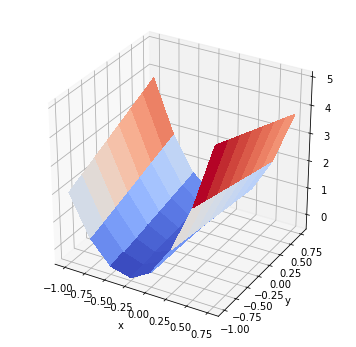

In [92]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f1(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [72]:
results1 = minimise_methods(Y1,f1_mean,N,n_iter)

Similar performance between KDE and MLE

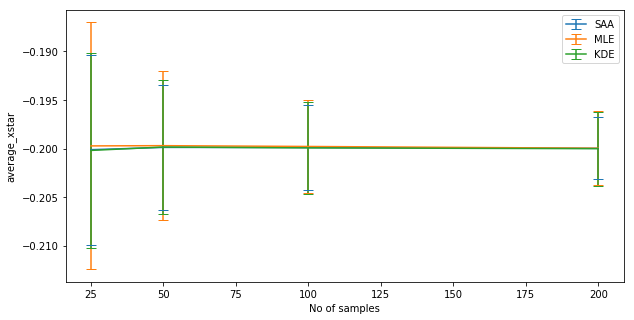

In [125]:
plot_result(results1)

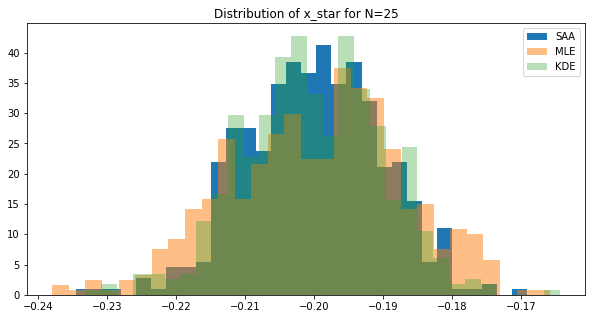

In [122]:
plot_result(results1,plot_histogram=True)

For sharply peaked distributions, KDE seems to underestimate the centre mass.

In [74]:
results2 = minimise_methods(Y2,f1_mean,N,n_iter)

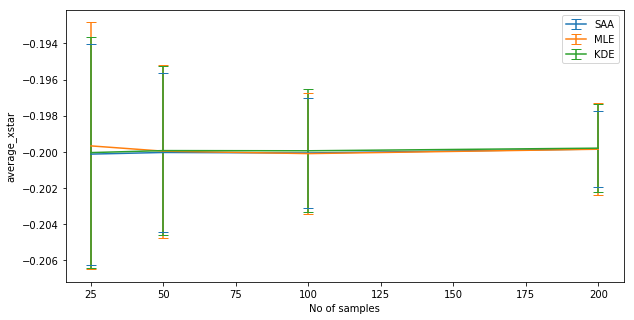

In [126]:
plot_result(results2)

Seems like SAA and KDE have the same deviation for slightly skewed distribution

In [76]:
results3 = minimise_methods(Y3,f1_mean,N,n_iter)

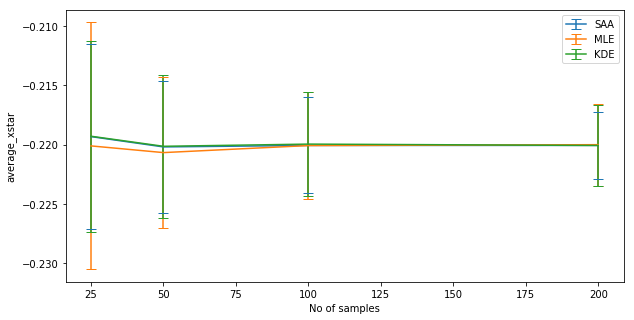

In [127]:
plot_result(results3)

Y4 is the heavy skewed distribution. seems like KDE and MLE either heavily underestimates the skew. Still doesn't explain why SAA performs much better in small sample sizes though..

In [78]:
results4 = minimise_methods(Y4,f1_mean,N,n_iter)

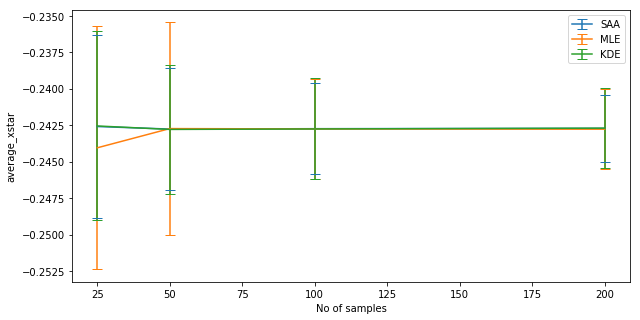

In [128]:
plot_result(results4)

## Results 2.2
These are the results for: <br>
            <center>$0.2x^2 -xy $</center>

Text(0.5,0,'y')

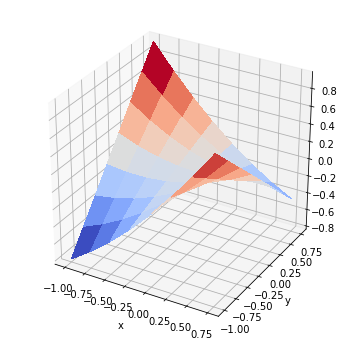

In [91]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f2(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [85]:
results1_f2 = minimise_methods(Y1,f2_mean,N,n_iter)

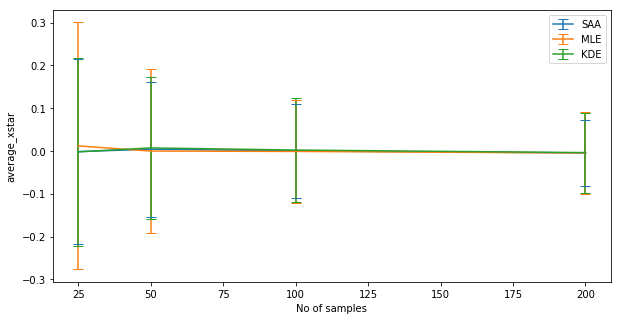

In [129]:
plot_result(results1_f2)

In [87]:
results2_f2 = minimise_methods(Y2,f2_mean,N,n_iter)

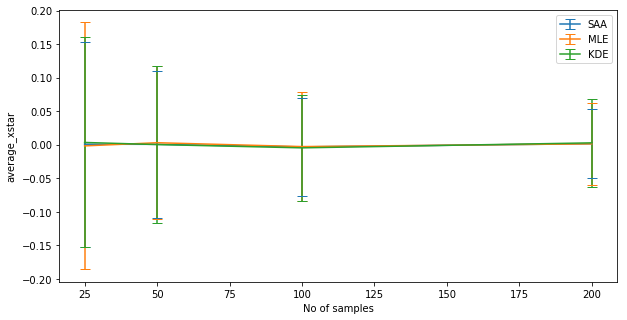

In [130]:
plot_result(results2_f2)

In [ ]:
results3_f2 = minimise_methods(Y3,f2_mean,N,n_iter)

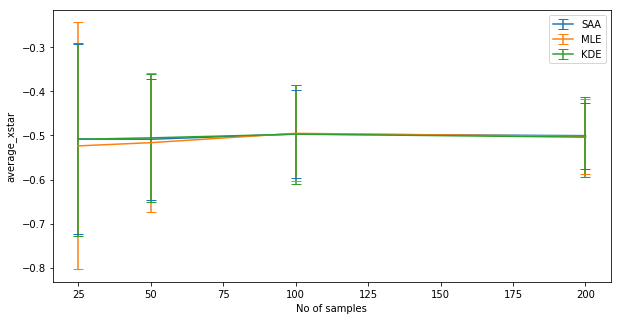

In [131]:
plot_result(results3_f2)

In [ ]:
results4_f2 = minimise_methods(Y4,f2_mean,N,n_iter)

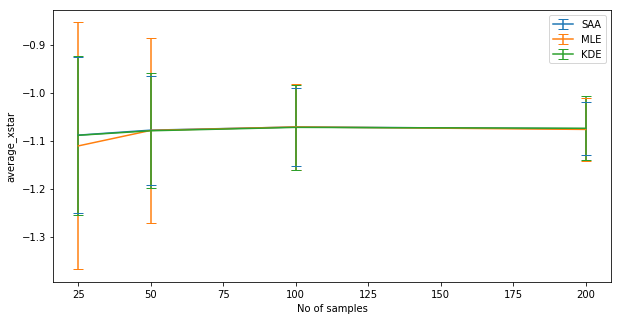

In [132]:
plot_result(results4_f2)

## Results
These are the results for: <br>
            <center>$ 3x^2 + 6xy^2 - 2x^2y - 7xy $</center>

Text(0.5,0,'y')

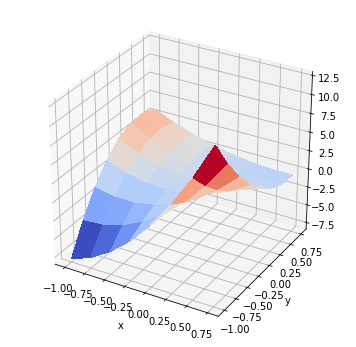

In [94]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [ ]:
results1_f3 = minimise_methods(Y1,f3_mean,N,n_iter)

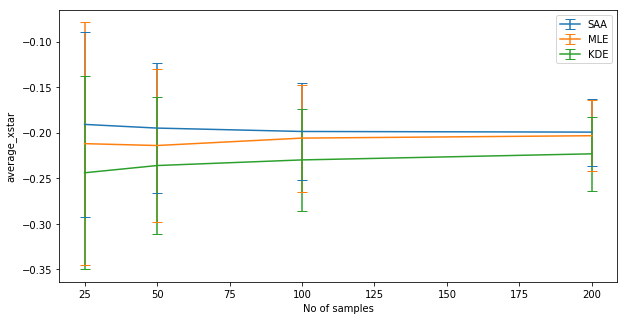

In [133]:
plot_result(results1_f3)

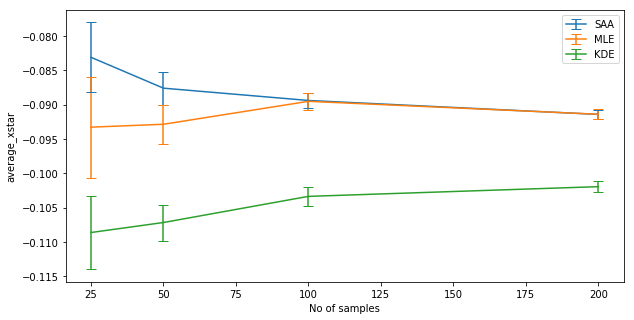

In [104]:
results2_f3 = minimise_methods(Y2,f3_mean,N,n_iter)
plot_result(results2_f3)

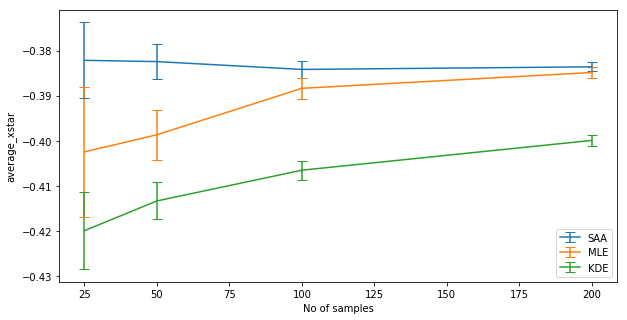

In [105]:
results3_f3 = minimise_methods(Y3,f3_mean,N,n_iter)
plot_result(results3_f3)

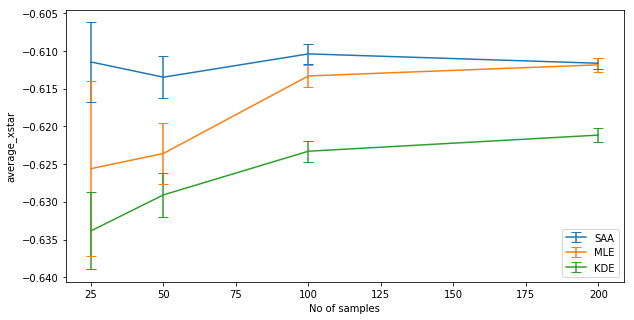

In [106]:
results4_f3 = minimise_methods(Y4,f3_mean,N,n_iter)
plot_result(results4_f3)